# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [26]:
#import libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


#My info
__author__ = "Dominick DiTucci"
__email__ = "djditucci@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
train_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_features.csv')
train_sal = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/train_salaries.csv')
test_feat = pd.read_csv('/Users/DJ/Salary-Prediction-Portfolio/data/test_features.csv')

# Check data we just loaded
train_feat.head()


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [3]:
train_sal.head()


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [4]:
test_feat.head()


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

In [5]:
# Look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it

# Check shape of our dataframes
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

# train_feat and test_feat have the same shape. train_feat and train_sal have overlapping 
# information, so let's combine them. We will leave test_feat alone so we can use it to predict 
# salaries after our model is developed

(1000000, 8)
(1000000, 2)
(1000000, 8)


In [6]:
# Join the 2 test dataframes by matching jobId
train_data = pd.merge(train_feat, train_sal, on ='jobId')

# Check merged datafram
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [7]:
# Check shape of merged df
train_data.shape

(1000000, 9)

In [8]:
# Check for invalid salaries (salaries at or below 0), show with jobid

zero_salary = train_data['salary']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

# There are 5 invalid salaries

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [9]:
# There are only 5/1,000,000 invalid salaries, so we'll remove them
train_data = train_data.drop(invalid_salary.index.tolist())

# See shape after deletion
train_data.shape

(999995, 9)

In [10]:
# Rest index after deletion
train_data.reset_index(drop=True, inplace=True)

# Check last 5 rows to see if index rest
train_data.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999990,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999994,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


In [11]:
# Check for any remaining missing values
missing_data = train_data.isnull().sum()
missing_data


jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [12]:
# jobId is irrelevant for prediction purposes, so we'll remove it

train_data.drop('jobId', axis=1, inplace=True)
train_data.drop('companyId', axis=1, inplace=True)

train_data.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [13]:
# See what types of data are in df
print(train_data.dtypes)

# All data types seem appropriate for their labels

jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
salary                  int64
dtype: object


In [14]:
# Define categorical variables
#train_data['companyId']=pd.Categorical(train_data['companyId'])
train_data['jobType']=pd.Categorical(train_data['jobType'])
train_data['degree']=pd.Categorical(train_data['degree'])
train_data['major']=pd.Categorical(train_data['major'])
train_data['industry']=pd.Categorical(train_data['industry'])
train_data.dtypes

jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

### ---- 4 Explore the data (EDA) ----

In [15]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

# Descriptive statistics of quantitative data
train_data.describe()

# Looking at min, max, mean, and std doesn't show anything obviously wrong

,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000
mean,11.992407,49.529381,116.062398
std,7.212390,28.877721,38.717163
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [16]:
# See how many unique values there are for each category
train_data.nunique()

jobType                  8
degree                   5
major                    9
industry                 7
yearsExperience         25
milesFromMetropolis    100
salary                 279
dtype: int64

In [17]:
# View relationshipes between quantitative data
train_data.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000672,0.375013
milesFromMetropolis,0.000672,1.000000,-0.297686
salary,0.375013,-0.297686,1.000000


### ---- 5 Establish a baseline ----

In [18]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation


# Assign dummy variables to categorical data, drop first variable in each category to avoid
# multicollinearity bias

train_data= pd.get_dummies(train_data, drop_first=True)
train_data.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,jobType_VICE_PRESIDENT,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,3,73,101,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,8,17,142,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0


In [30]:
# Create training model
X = train_data[train_data.loc[ : , train_data.columns != 'salary'].columns]
y = train_data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [31]:
print('Inputs: \n', X_train.head())
print('Outputs: \n', y_train.head())

Inputs: 
         yearsExperience  milesFromMetropolis  jobType_CFO  jobType_CTO  \
192873               15                   92            0            0   
483391                6                   34            0            0   
660873               15                   80            0            0   
487542                4                   76            0            0   
175915               14                   54            0            0   

        jobType_JANITOR  jobType_JUNIOR  jobType_MANAGER  jobType_SENIOR  \
192873                0               0                0               0   
483391                0               1                0               0   
660873                0               0                0               0   
487542                0               0                0               0   
175915                0               1                0               0   

        jobType_VICE_PRESIDENT  degree_DOCTORAL      ...       \
192873                 

In [21]:
# Create logistic regression object and fit model
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [22]:
# Model performance
# scores = cross_val_score(logreg, X_train, y_train, cv=5)
# print('5-Fold CV Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Baseline model gives accuracy score of 1.8%

/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/DJ/anaconda3/lib/python3.7/site-packages/s

5-Fold CV Accuracy: 0.018 +/- 0.000


In [21]:
# Use Linear Regression since salary is continuous range.
# Create linear regression object and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
# View coefficients
print(lm.intercept_)
print(lm.coef_)
zip(X, lm.coef_)

134.84393724008567
[  2.01084754  -0.39964793  -9.7806845   -9.78566105 -62.35521236
 -49.7549217  -29.84811774 -39.75756335 -19.8963678   10.01222737
  -5.74040222   4.98918015  -9.45219035   7.69414468   1.13444715
   4.06735942  10.62826839  -3.62611173   5.22209912  -4.8965001
   2.37367768 -10.04270573  21.11833197   6.2328718   21.30184083
  -4.96611536  12.09809033]


In [34]:
# Predict y given X (yhat) and view 1st 5 predictions
yhat = lm.predict(X_train)
print("The output of the first five predicted values are:", yhat[0:5])

The output of the first five predicted values are: [135.1921912   84.90244288 119.9080897  109.02305769  95.69677397]


In [36]:
# Find MSE
print("The mean squared error of our prediciton model is:", mean_squared_error(y_train, yhat))

The mean squared error of our prediciton model is: 384.6016627263652


In [37]:
# Model Performance
scores = cross_val_score(lm, X_train, y_train, cv=5)
print("5-Fold Cross Validation Accuracy: %.3f +/- %.3f", np.mean(scores), np.std(scores))

5-Fold Cross Validation Accuracy: %.3f +/- %.3f 0.7432154161993711 0.0007096460284499192


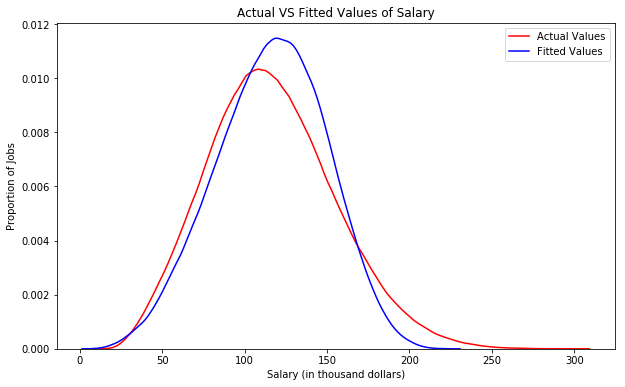

In [39]:
# View distribution of actual vs fitted
plt.figure(figsize=(10, 6))

ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Values")
sns.distplot(yhat, hist=False, color="b", label="Fitted Values", ax=ax1)

plt.title("Actual VS Fitted Values of Salary")
plt.xlabel("Salary (in thousand dollars)")
plt.ylabel("Proportion of Jobs")
plt.show()
plt.close()

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data